
### T1 Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2024  

In [1]:
import sys
# Add the parent directory to the system path
sys.path.insert(1, r"C:\Users\keena\Documents\University\python_scripts")

from Function_files.addresses import Init_Directories
import Function_files.data_functions as dat
from Function_files.fitting_functions import find_trigger, fit_exp_decay
from Function_files.math_functions import average_arrays
from Function_files.plotting_class import Plotter

plt = Plotter()
dirs = Init_Directories()

from scipy.integrate import simpson

dirs.current = dirs.join(dirs.code, "Lifetime\T1")
json = dirs.join(dirs.current, "configs", "0925.json")
info = dat.read_json(json)


##### Import Data  
        
        Load data sets & extract time and voltage data


In [2]:
# path to folders containing T1 data
path = dirs.join(info['file_loc'], "traces")
# indexes for data
di = info['data_indexes']
ti = info['trim_indexes']
# make labels from data indexes
labels = [key for key in di.keys() if key != 'time']
# populate folder and file lists
folder_list, file_list = dat.dir_interrogate(path, extensions=info['extensions'])
# create dictionary for indexing folders and files
folder_index = dat.make_index_dict(folder_list)
file_index = [dat.make_index_dict(file_sub_list) for file_sub_list in file_list]
# lists of the data paths and metadata (text) paths
data_path_list = dat.search_paths(folder_list, file_list, [info['extensions'][0]])
metadata_path_list = dat.search_paths(folder_list, file_list, [info['extensions'][1]])
# extract the relevant data from the files
excel_sets = [[dat.open_csv(dirs.join(path, data_path), header=0) for data_path in data_paths] for data_paths in data_path_list]
if '.txt' in info['extensions']:
        metadata = [dat.open_text(dirs.join(path, data_path)) for data_paths in metadata_path_list for data_path in data_paths]
        fluor_duration = [[float(dat.find_numbers(row)[0]) for row in text_file if dat.check_str(["durationFluor"], row.split())] for text_file in metadata]
elif '.json' in info['extensions']:
        metadata = [dat.read_json(dirs.join(path, data_path)) for data_paths in metadata_path_list for data_path in data_paths]
        fluor_duration = [[data['pi_half_params']['duration'] for data in meta_files] for meta_files in [metadata]]


##### Fine Tune Trigger Point

        Check the trigger index and adjust if neccesary
        

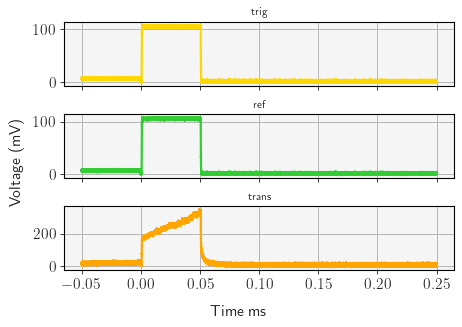

In [3]:
# plot channel data to check assignment (times are in us)
set = 0         # data set to use
file = 0         # file in the data set
plt.scale_x = 1E3
plt.scale_y = 1E3
fig, ax = plt.plot_scope(excel_sets[set][file][:,di['time']], [excel_sets[set][file][:,di['trig']], excel_sets[set][file][:,di['ref']], excel_sets[set][file][:,di['trans']]], titles=labels, multi=True)

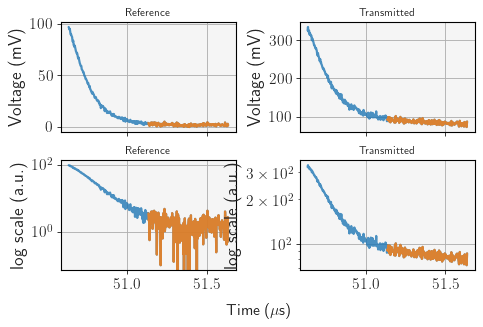

In [4]:
# find index of the trigger
set = 0          # data set to use
file = 0        # file in the data set
trig_indexes = [[find_trigger(trig_data[:,di['trig']], modifier=.9, edge='fall') for trig_data in excel_data] for excel_data in excel_sets]
ti['trig'] = trig_indexes[set][file]
# calculate the time step
dt = (excel_sets[set][file][:,di['time']][1] - excel_sets[0][0][:,di['time']][0])*1E6
# create offset based on time step
fix_indexes = True
if fix_indexes:
    ti['ramp'] = round(1/dt) + trig_indexes[set][file]         # extend plotted data
    ti['off'] = round(0.5/dt)                                     # offset to add to trigger  
    ti['ref_off'] = round(0.5/dt)                                 # reference offset  
    #dat.write_file(json, info, 'json')

# plot transmitted and reference data to check the trigger index
plt.scale_x = 1E6
plt.scale_y = 1E3
fig, ax = plt.plot_T1_trigger(excel_sets[set][file][:,di['time']], [excel_sets[set][file][:,di['ref']], excel_sets[set][file][:,di['trans']]], ti)


##### Process Data  

        Trim the data sets and find initial starting parameters for fitting
        Fit to the data and take average fit values


In [ ]:
# # find start and stop indexes for the data (saves trying to fit to unnecesary data)
ref_stop_set = [[round(info['guess_ref_T1']*4/(time[:,di['time']][1] - time[:,di['time']][0])) for time in time_lists] for time_lists in excel_sets]
stop_set = [[round(info['guess_T1']*1.5 /(time[:,di['time']][1] - time[:,di['time']][0])) for time in time_lists] for time_lists in excel_sets]
start_set = [[value + ti['off'] for value in trig_index] for trig_index in trig_indexes]
ref_start_set = [[value + ti['ref_off'] for value in trig_index] for trig_index in trig_indexes]
# create new arrays of cut data using start and stop indexes found
time_sets = [[data[:,di['time']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, start_set, stop_set)]
ref_time_sets = [[data[:,di['time']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, ref_start_set, ref_stop_set)]
trig_sets = [[data[:,di['trig']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, start_set, stop_set)]
trans_sets = [[data[:,di['trans']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, start_set, stop_set)]
ref_sets = [[data[:,di['ref']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, ref_start_set, ref_stop_set)]
# found initial start params for the fitting functions (minimum and maximum)
list_of_mins = [[min(trans) for trans in trans_lists] for trans_lists in trans_sets]
list_of_maxs = [[max(trans) for trans in trans_lists] for trans_lists in trans_sets]
ref_min_list = [[min(refs) for refs in ref_lists] for ref_lists in ref_sets]
ref_max_list = [[max(refs) for refs in ref_lists] for ref_lists in ref_sets]
# zip the fit data for the reference signal
ref_zip = zip(ref_time_sets, ref_sets, ref_max_list, ref_min_list)
data_zip = zip(time_sets, trans_sets, list_of_maxs, list_of_mins)
# fit to the reference data
ref_fit_sets = [[fit_exp_decay(time, ref, params=(max_value, info['guess_ref_T1'], min_value)) for time, ref, max_value, min_value in zip(time_set, ref_set, max_set, min_set)] for time_set, ref_set, max_set, min_set in ref_zip]
# fit to the transmitted data
data_fit_sets = [[fit_exp_decay(time, trans, params=(max_value, info['guess_T1'], min_value)) for time, trans, max_value, min_value in zip(time_set, trans_set, max_set, min_set)] for time_set, trans_set, max_set, min_set in data_zip]
# calculate area of the fluorescence
data_area_sets = [[simpson(y=trans, x=time) for trans, time in zip(trans_set, time_set)] for trans_set, time_set in zip(trans_sets, time_sets)]
# calculate averages
#ref_fit_avg = [average_arrays(ref_list) for ref_list in ref_fit_sets]
data_fit_avg = [average_arrays(data_list) for data_list in data_fit_sets]
data_area_avg = [average_arrays(data_list) for data_list in data_area_sets]

In [18]:
import matplotlib.pyplot as mp
from Function_files.fitting_functions import exp_decay

def plot_T1_fit(time, data, fit_params):
        '''
        Plot T1 fitted data on top of experimental data

        Parameters
        ----------
        time: array
            Time data for corresponding fit_params
        data: array
            Y data for the corresponding fit_params
        fit_params: list / tuple
            Fit parameters to use in exp_decay function 

        Returns
        -------
        fig, ax: 
            Figure and axes handles for the plot

        '''
        if type(fit_params) == tuple:
            fit = fit_params[0]
        else:
            fit = fit_params

        scale_x = 1E6
        scale_y = 1E3

        # make label for plots
        scale_time = time * scale_x

        fig_1, ax_1 = mp.subplots()
        
        ax_1.plot(scale_time, (data - fit[-1]) * scale_y, color='C0', alpha=0.8, label='Exp. Data')
        ax_1.plot(scale_time, (exp_decay((time), *fit) - fit[-1]) * scale_y, color='C1', linestyle='--', alpha=1, label='Fit')
        ax_1.set_yscale('linear')
        ax_1.set(ylabel=f'Voltage (mV)')
        ax_1.legend()
        ax_1.set(xlabel=f'Time ($\\mu$s)')

        fig_2, ax_2 = mp.subplots()

        ax_2.plot(scale_time, (data - fit[-1]) * scale_y, color='C0', alpha=0.8, label='Exp. Data')
        ax_2.plot(scale_time, (exp_decay((time), *fit) - fit[-1]) * scale_y, color='C1', linestyle='--', alpha=1, label='Fit')
        ax_2.set_yscale('log')
        ax_2.set(ylabel=f'$\log_1$$_0$ Voltage (mV)')
        ax_2.legend()
        ax_2.set(xlabel=f'Time ($\\mu$s)')

        return fig_2, ax_2

In [19]:
from Function_files.addresses import Init_Directories
dirs = Init_Directories()
plt.format = 'svg'
plt.dir = dirs.code
plt.folder = "Lifetime/T1/fit_data/PrYSO_05pc/"
plt.fname = 'log T1'
#plt.save_fig(figure=fig)

In [ ]:
fig, ax = plot_T1_fit(time_sets[0][0], trans_sets[0][0], data_fit_sets[0][0])
print(data_fit_sets[0][0])

In [23]:
keys = ['I0', 'T1', 'y0']
err_keys = ['dI0', 'dT1', 'dy0']
fit_data = {}

for duration, data_fit, data_area in zip(fluor_duration, data_fit_avg, data_area_avg):
    duration_dict = {}
    for key, value in zip(keys, data_fit[0][0].flatten().tolist()):
        duration_dict[key] = value
    for key, value in zip(err_keys, data_fit[1][0].flatten().tolist()):
        duration_dict[key] = value
    # Add area to the dict
    duration_dict['A'] = data_area[0]
    duration_dict['dA'] = data_area[1]
    # After populating duration_dict with all key-value pairs, assign it to fit_data
    fit_data[duration[0]] = duration_dict

In [ ]:
# save the data to file
dat.write_json(dirs.join(dirs.current, fit_data), fit_data)